In [ ]:
from ultralytics import YOLO
import ultralytics
from pathlib import Path
import pandas as pd
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from PIL import Image

DATASET_BASE_NAME = "Weed-crop RGB dataset" 
TARGET_CROP_NAME = "Black bean"    

# --- MODEL AND TRAINING CONSTANTS ---
MODEL_NAME = "yolo11n.pt"  # Base model weights to be used
IMG_SIZE = 640             # Image size for training/testing
BATCH_SIZE = 4             # Batch size
EPOCHS = 150               # Number of epochs
PATIENCE = 0              # Early stopping patience
DEVICE_ID = 0              # GPU device ID (e.g., 0)
RUNS_BASE_DIR = Path("runs") # Parent directory for all YOLO results

# --- DATASET CONFIGURATION (Dynamic Paths) ---
DATASET_ROOT = Path(DATASET_BASE_NAME)
AUG_DIR_NAME = f"{TARGET_CROP_NAME}_augmented"
DATA_CONFIG_AUG = DATASET_ROOT / AUG_DIR_NAME / f"{TARGET_CROP_NAME.lower()}_augmented.yaml" 
DATA_CONFIG_ORIGINAL = DATASET_ROOT / AUG_DIR_NAME / f"{TARGET_CROP_NAME.lower()}_original.yaml" 
CLASSES_FILE = DATASET_ROOT / AUG_DIR_NAME / "classes.txt"
JSON_FILE_PATH = DATASET_ROOT / AUG_DIR_NAME / f"{TARGET_CROP_NAME.lower()}_stats.json"

ORIGINAL_PROJECT_NAME = f"{TARGET_CROP_NAME}_original"
AUGMENTED_PROJECT_NAME = f"{TARGET_CROP_NAME}_augmented"

ORIGINAL_OUTPUT_DIR = RUNS_BASE_DIR / ORIGINAL_PROJECT_NAME

AUGMENTED_OUTPUT_DIR = RUNS_BASE_DIR / AUGMENTED_PROJECT_NAME

def get_final_paths(base_path, experiment_name):
    run_folder = base_path / experiment_name 
    return {
        'weights': run_folder / 'weights' / 'best.pt',
        'plot_pr': run_folder / 'evaluation' / 'BoxPR_curve.png',
        'plot_res': run_folder / 'results.png'
    }

ORIGINAL_PATHS = get_final_paths(RUNS_BASE_DIR, ORIGINAL_PROJECT_NAME)
AUGMENTED_PATHS = get_final_paths(RUNS_BASE_DIR, AUGMENTED_PROJECT_NAME)

# Ablation Study: Original vs Augmented Dataset

This notebook performs an ablation study to evaluate the impact of context-aware undersampling on YOLO11n model performance. We compare two training scenarios:

1. **Original Dataset:** Model trained on the unmodified Black bean dataset with severe class imbalance
2. **Augmented Dataset:** Model trained on the preprocessed dataset with balanced class distribution

The study aims to determine whether reducing the majority class (Black bean) through intelligent undersampling improves detection performance for minority weed classes without critically compromising overall accuracy.

## Experimental Setup

**Model Configuration:**
- Base Architecture: YOLO11n (yolo11n.pt)
- Input Size: 640x640 pixels
- Training: 150 epochs, batch size 4, early stopping disabled (patience=0)
- Hardware: GPU-based training (device_id=0)

**Dataset:**
- Source: Mendeley Weed-crop RGB dataset
- Target Crop: Black bean
- Classes: 5 weed species (Horseweed, Kochia, Ragweed, Redroot Pigweed, Waterhemp) + crop species

# Ablation study - what do we expect to happen?

The core challenge in applying object detection to this agricultural dataset is the severe class imbalance between the majority crop and the minority weed classes. To address this, we implemented a context-aware undersampling strategy focused on mitigating noise caused by low-context crop instances at image borders. This targeted preprocessing successfully reduced the majority class (Black bean) instance count by 48.3% overall (from 1382 to 715 total instances), corresponding to a 47.7% reduction in the training split (from 1727 to 903 instances). We expect the model trained on augmented data to achieve better performance on minority weed class detection due to reduced class imbalance, while maintaining comparable overall accuracy. 

In [2]:
def load_class_names_from_file(file_path):
    with open(file_path, 'r') as f:
        class_names = {str(i): line.strip() for i, line in enumerate(f)}
    return class_names

CLASS_NAMES = load_class_names_from_file(CLASSES_FILE)
with open(JSON_FILE_PATH, 'r') as f:
    stats_data = json.load(f)

df_stats = pd.DataFrame.from_dict(stats_data, orient='index').T
df_stats = df_stats.fillna(0).astype(int) 
df_stats['deleted instances'] = df_stats['train'] - df_stats['train_augmented']
new_index_names = [CLASS_NAMES.get(idx, idx) for idx in df_stats.index.astype(str)]
df_stats.index = new_index_names
columns_to_display = ['train', 'train_augmented', 'deleted instances']
print("--- Detailed Class Distribution and Augmentation Impact ---")
display(df_stats[columns_to_display])

--- Detailed Class Distribution and Augmentation Impact ---


,train,train_augmented,deleted instances
Redroot Pigweed,80,80,0
Kochia,85,85,0
Black bean,1727,903,824
Waterhemp,95,95,0
Ragweed,99,99,0
Horseweed,50,50,0
Soybean,20,19,1
Flax,0,0,0
Lentil,0,0,0


## Class Distribution Analysis

The table below shows the impact of context-aware undersampling on the training set. The preprocessing algorithm targeted low-context Black bean instances at image borders while preserving all minority weed classes.

# Model training on Original Dataset

---

# Training Phase

Two separate YOLO11n models are trained from scratch using identical hyperparameters. The only difference is the training dataset: one uses the original unbalanced data, the other uses the augmented balanced data.

In [3]:
original_model = YOLO(MODEL_NAME)

baseline_train_results = original_model.train(
    data=str(DATA_CONFIG_ORIGINAL),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=ORIGINAL_PROJECT_NAME,  
    project=RUNS_BASE_DIR,   
    device=DEVICE_ID,
    patience=PATIENCE,
    exist_ok=True
)

print(f"Original dataset model saved to: {ORIGINAL_PATHS['weights'].parent}")

New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Weed-crop RGB dataset/Black bean_augmented/black bean_original.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, m

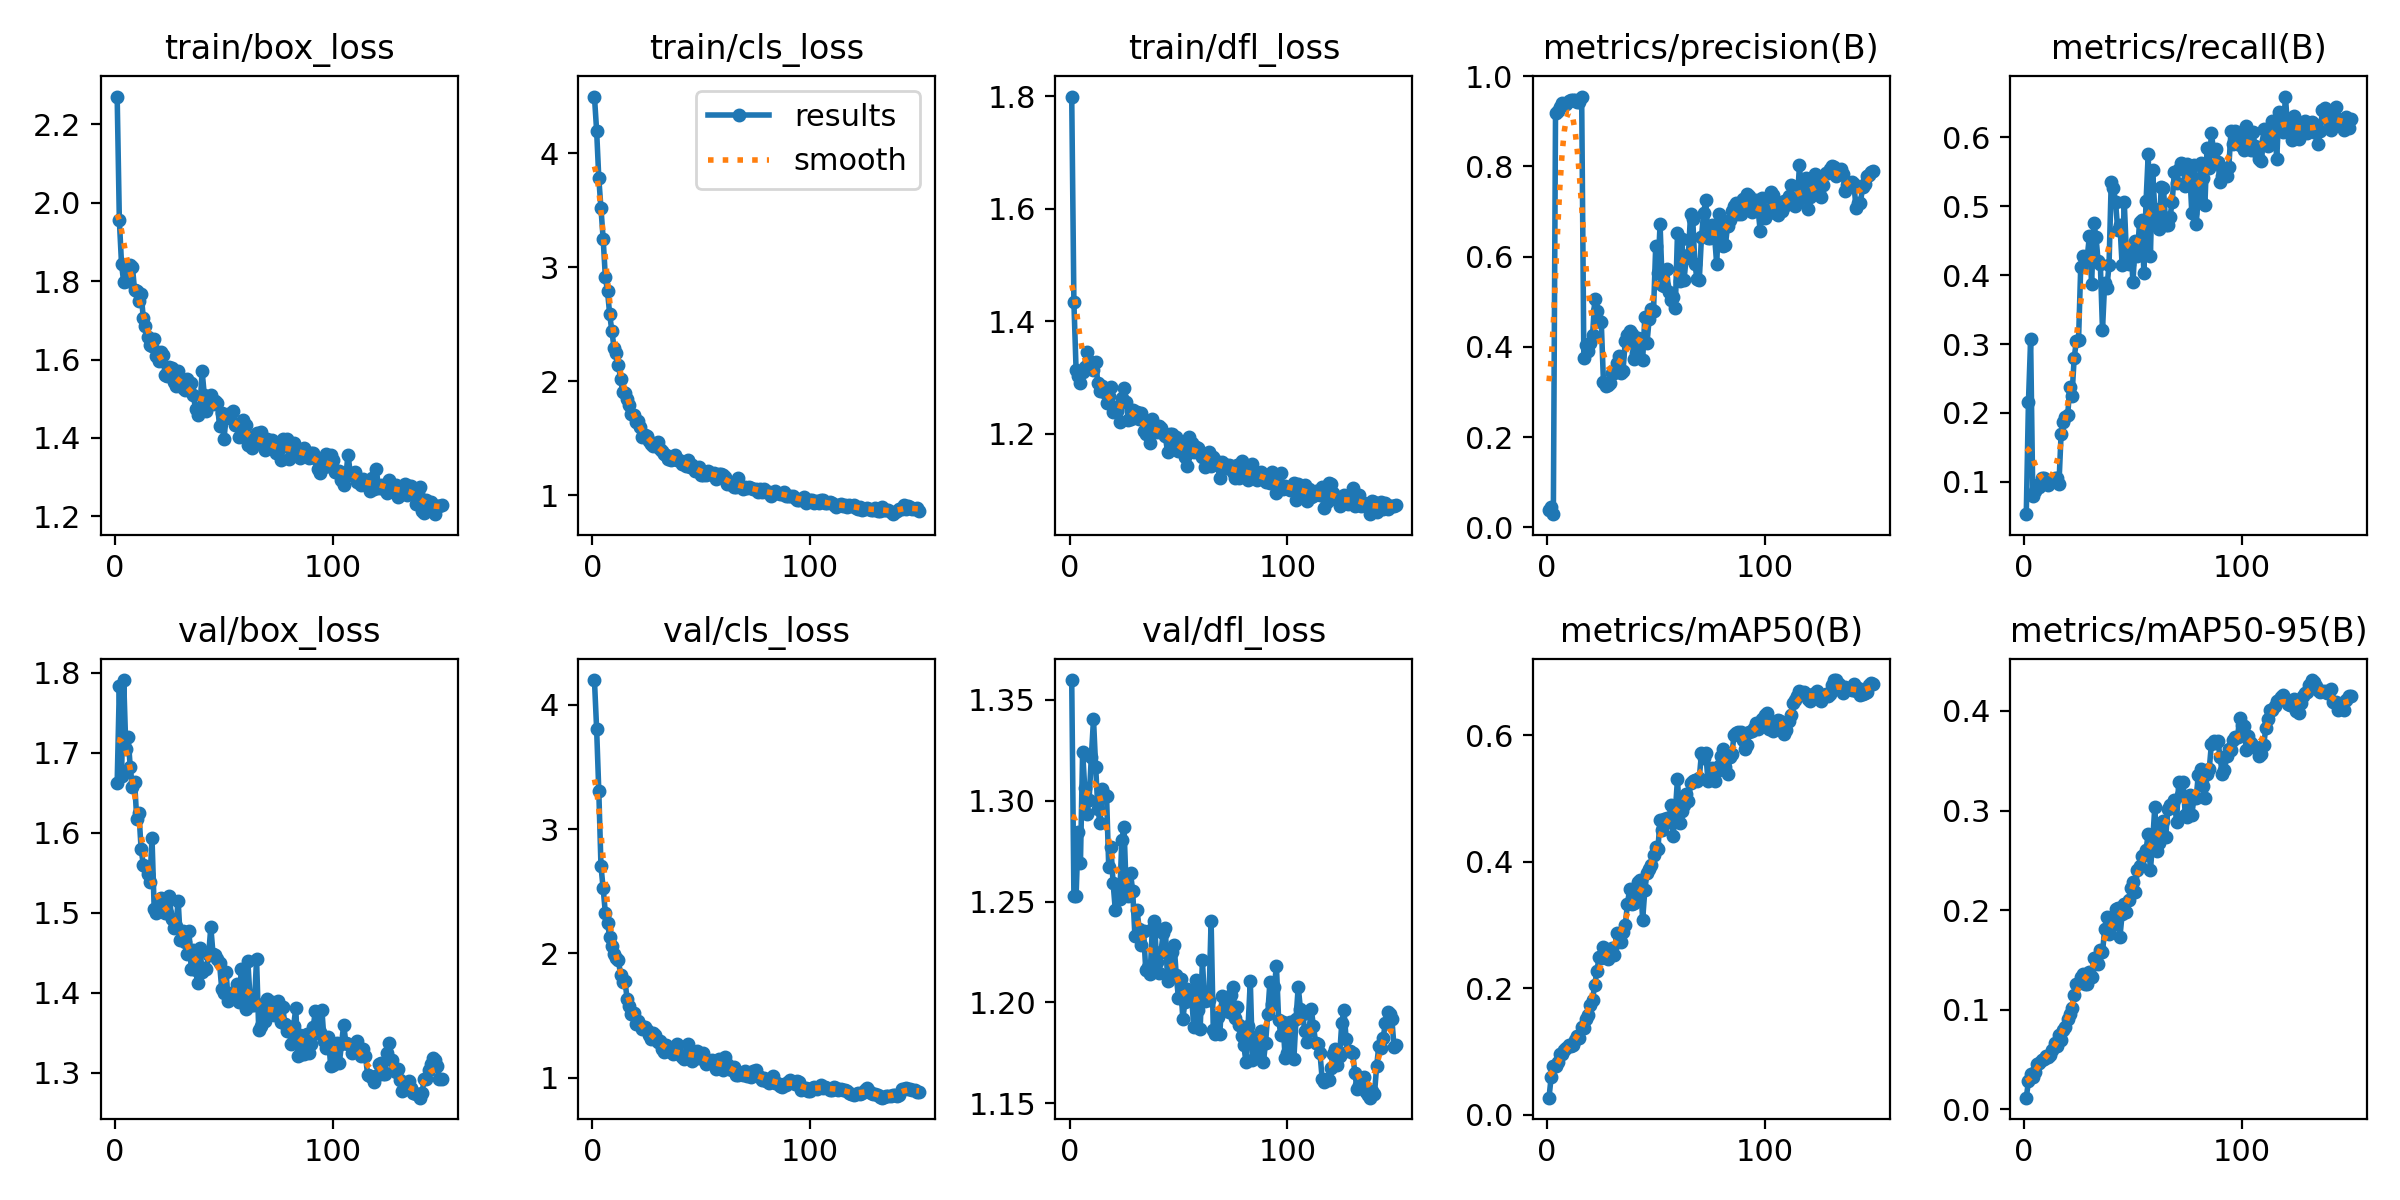

In [4]:

original_plot_path = ORIGINAL_PATHS['plot_res']
img_original = Image.open(original_plot_path)
display(img_original)


### Training Results Visualization

The plot below shows key training metrics (loss curves, precision, recall, mAP) across all epochs for the original dataset model.

In [5]:
BEST_WEIGHTS_PATH = ORIGINAL_PATHS['weights'] 

final_trained_model = YOLO(str(BEST_WEIGHTS_PATH))

export_name = f"{TARGET_CROP_NAME.lower()}_yolo11n_original.pt"
export_path = RUNS_BASE_DIR / export_name
final_trained_model.save(export_path)

print(f"Model saved to: {export_path}")

Model saved to: runs/black bean_yolo11n_original.pt


## Model training on Augmented Dataset

In [ ]:
augmented_model = YOLO(MODEL_NAME)

augmented_train_results = augmented_model.train(
    data=str(DATA_CONFIG_AUG),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=AUGMENTED_PROJECT_NAME,  
    project=RUNS_BASE_DIR,   
    device=DEVICE_ID,
    patience=PATIENCE,
    exist_ok=True
)

print(f"Augmented dataset model saved to: {AUGMENTED_PATHS['weights'].parent}")

New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Weed-crop RGB dataset/Black bean_augmented/black bean_augmented.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, 

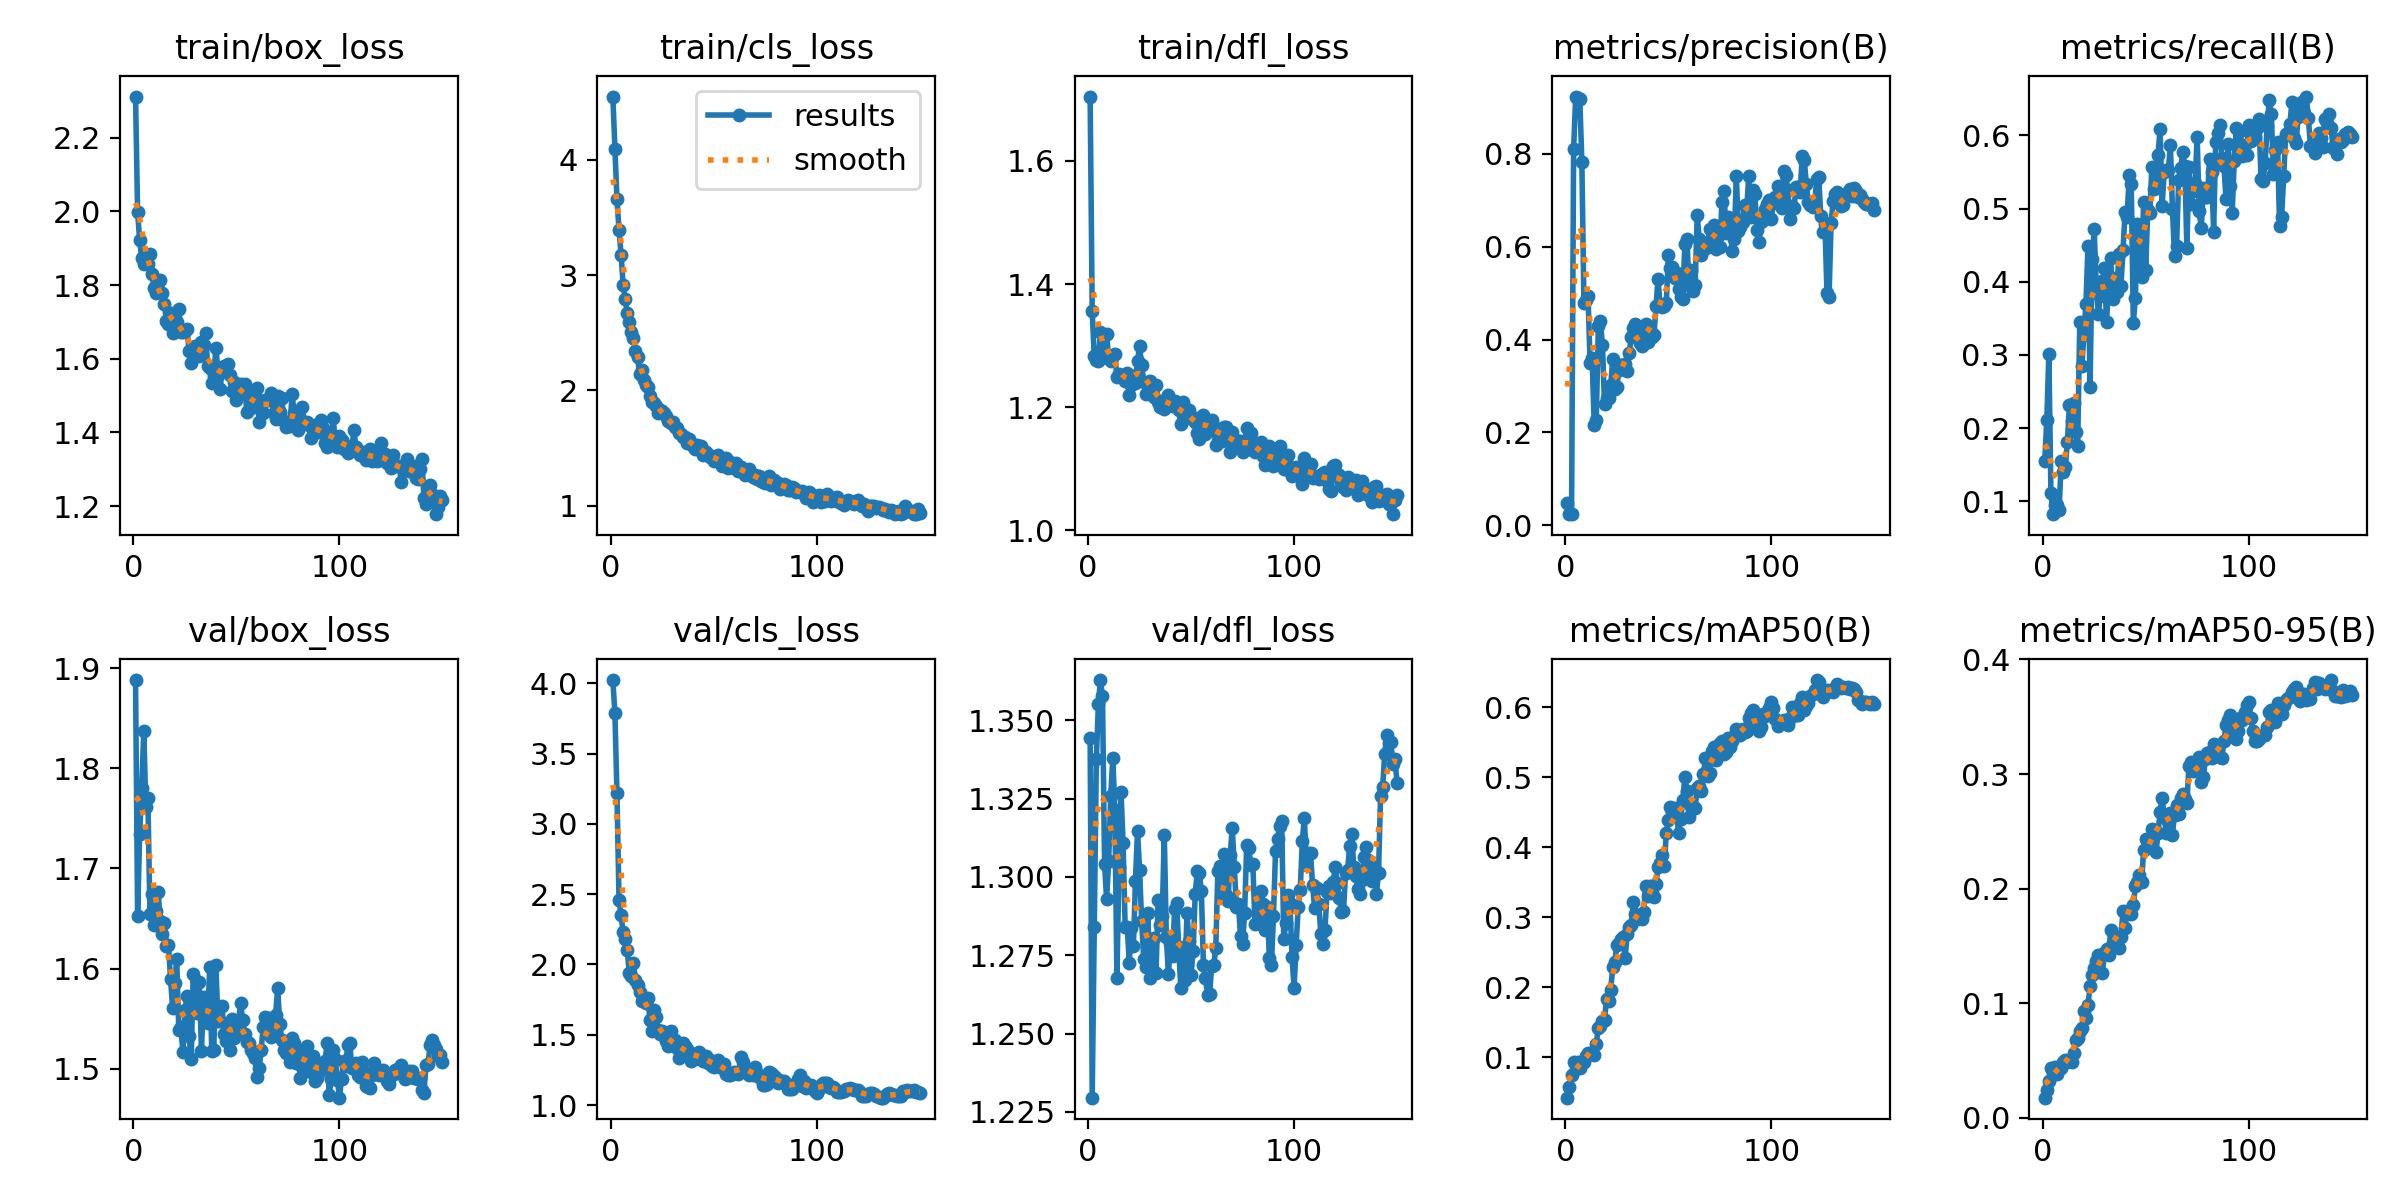

In [ ]:

augmented_plot_path = AUGMENTED_PATHS['plot_res']
img_augmented = Image.open(augmented_plot_path)
display(img_augmented)

### Training Results Visualization

The plot below shows key training metrics (loss curves, precision, recall, mAP) across all epochs for the augmented dataset model.

In [ ]:
BEST_WEIGHTS_PATH = AUGMENTED_PATHS['weights'] 

final_trained_model = YOLO(str(BEST_WEIGHTS_PATH))

export_name = f"{TARGET_CROP_NAME.lower()}_yolo11n_augmented.pt"
export_path = RUNS_BASE_DIR / export_name
final_trained_model.save(export_path)

print(f"Model saved to: {export_path}")

Model saved to: runs/black bean_yolo11n_augmented.pt


# Evaluation on test dataset

---

### Model trained on original dataset evaluation

In [4]:

BEST_MODEL_PATH = ORIGINAL_PATHS['weights'] 
print(f"Loading best model from: {BEST_MODEL_PATH}")
final_model = YOLO(str(BEST_MODEL_PATH))

print("\n--- Final Evaluation on TEST Dataset ---")
original_metrics = final_model.val(
    data=str(DATA_CONFIG_ORIGINAL), 
    split='test',      
    imgsz=IMG_SIZE,
    project=str(ORIGINAL_OUTPUT_DIR),
    name = "evaluation"
)

print(original_metrics)
print("\n--- Results on Test Set ---")
print(f"Mean Average Precision (mAP50-95): {original_metrics.box.map:.4f}")
print(f"mAP50 (Test): {original_metrics.box.map50:.4f}")

if hasattr(original_metrics.box.mr, 'mean'):
    print(f"Recall (Test): {original_metrics.box.mr.mean():.4f}")
else:
    print(f"Recall (Test): {original_metrics.box.mr:.4f}")

Loading best model from: runs/Black bean_original/weights/best.pt

--- Final Evaluation on TEST Dataset ---
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7867.0±1658.9 MB/s, size: 5859.4 KB)
val: Scanning /home/jula/Repositories/CV/project/crop-weed-detection-1.2/Weed-crop RGB dataset/Black bean_augmented/test.cache... 39 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 39/39 100.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.6it/s 5.0s2.6ss
                   all         39        606      0.877      0.481      0.609      0.365
            Black bean         38        446      0.855      0.883      0.915      0.586
                  Flax          1          3          1          0          0          0
           

### Model trained on augmented dataset evaluation

In [3]:
BEST_MODEL_PATH = AUGMENTED_PATHS['weights'] 
print(f"Loading best model from: {BEST_MODEL_PATH}")
final_model = YOLO(str(BEST_MODEL_PATH))

print("\n--- Final Evaluation on TEST Dataset ---")
augmented_metrics = final_model.val(
    data=str(DATA_CONFIG_AUG), 
    split='test',      
    imgsz=IMG_SIZE,
    project=str(AUGMENTED_OUTPUT_DIR),
    name = "evaluation"
)

print(augmented_metrics)
print("\n--- Results on Test Set ---")
print(f"Mean Average Precision (mAP50-95): {augmented_metrics.box.map:.4f}")
print(f"mAP50 (Test): {augmented_metrics.box.map50:.4f}")

if hasattr(augmented_metrics.box.mr, 'mean'):
    print(f"Recall (Test): {augmented_metrics.box.mr.mean():.4f}")
else:
    print(f"Recall (Test): {augmented_metrics.box.mr:.4f}")

Loading best model from: runs/Black bean_augmented/weights/best.pt

--- Final Evaluation on TEST Dataset ---
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 949.3±41.1 MB/s, size: 4766.3 KB)
val: Scanning /home/jula/Repositories/CV/project/crop-weed-detection-1.2/Weed-crop RGB dataset/Black bean_augmented/test.cache... 39 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 39/39 110.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.7it/s 4.5s2.8ss
                   all         39        606      0.846      0.566       0.63      0.397
            Black bean         38        446      0.826      0.778       0.84      0.486
                  Flax          1          3          1          0          0          0
             

### Report

---

In [5]:
def extract_class_metrics(metrics_obj, label):

    evaluated_iids = metrics_obj.box.ap_class_index.tolist()
    
    ap50_arr = metrics_obj.box.ap50.flatten().tolist()
    ap_arr = metrics_obj.box.ap.flatten().tolist()

    full_class_names = metrics_obj.names
    
    nc_evaluated = len(ap50_arr) 
    
    data_list = []
    
    for i in range(nc_evaluated): 
        
        class_id = evaluated_iids[i]
        class_name = full_class_names[class_id]
        
        data_list.append({
            'Class': class_name, 
            f'mAP@0.5 ({label})': ap50_arr[i],
            f'mAP@0.5:0.95 ({label})': ap_arr[i]
        })

    df = pd.DataFrame(data_list)
    
    df = df[(df[f'mAP@0.5 ({label})'] > 0) | (df[f'mAP@0.5:0.95 ({label})'] > 0)]
    df.set_index('Class', inplace=True)
    return df

def extract_general_metrics(metrics_obj, label):
    
    mp = metrics_obj.box.mp
    mr = metrics_obj.box.mr
    
    precision = mp.mean() if hasattr(mp, 'mean') else mp
    recall = mr.mean() if hasattr(mr, 'mean') else mr
    
    data = {
        'Metric': ['mAP@0.5', 'mAP@0.5:0.95', 'Precision (P)', 'Recall (R)'],
        label: [metrics_obj.box.map50, metrics_obj.box.map, precision, recall]
    }
    df = pd.DataFrame(data).set_index('Metric')
    return df

In [6]:
def extract_general_metrics(metrics_obj, label):
    
    mp = metrics_obj.box.mp
    mr = metrics_obj.box.mr
    
    total_time_ms = metrics_obj.speed['preprocess'] + metrics_obj.speed['inference'] + metrics_obj.speed['postprocess']
    fps = 1000 / total_time_ms 
    
    precision = mp.mean() if hasattr(mp, 'mean') else mp
    recall = mr.mean() if hasattr(mr, 'mean') else mr

    #ap_small = metrics_obj.box.ap[7] if len(metrics_obj.box.ap) > 7 else 0 

    
    data = {
        'Metric': ['mAP@0.5', 'mAP@0.5:0.95', 'Precision (P)', 'Recall (R)', 
                   #'AP_Small (APs)', 
                   'Inference FPS'],
        label: [
            metrics_obj.box.map50, 
            metrics_obj.box.map, 
            precision, 
            recall,
            #ap_small, 
            fps
        ]
    }
    df = pd.DataFrame(data).set_index('Metric')
    return df

In [7]:

df_augmented_general = extract_general_metrics(augmented_metrics, 'Augmented')
df_original_general = extract_general_metrics(original_metrics, 'Original')

df_general_comparison = df_augmented_general.join(df_original_general, how='outer')
df_general_comparison['Difference'] = df_general_comparison['Original'] - df_general_comparison['Augmented']

print("\n--- Model Comparison: Overall Metrics  ---")
display(df_general_comparison.round(4))

df_augmented_class = extract_class_metrics(augmented_metrics, 'Augmented')
df_original_class = extract_class_metrics(original_metrics, 'Original')

df_class_comparison = df_augmented_class.join(df_original_class, how='outer').fillna(0)
df_class_comparison['Diff mAP@0.5'] = df_class_comparison['mAP@0.5 (Augmented)'] - df_class_comparison['mAP@0.5 (Original)'] 
df_class_comparison['Diff mAP@0.5:0.95'] = df_class_comparison['mAP@0.5:0.95 (Augmented)'] - df_class_comparison['mAP@0.5:0.95 (Original)']

print("\n--- Model Comparison: Class-Wise Details ---")
display(df_class_comparison.round(4))


--- Model Comparison: Overall Metrics  ---


,Augmented,Original,Difference
Metric,,,
Inference FPS,21.5939,44.5830,22.9891
Precision (P),0.8461,0.8767,0.0306
Recall (R),0.5656,0.4806,-0.0850
mAP@0.5,0.6304,0.6092,-0.0212
mAP@0.5:0.95,0.3967,0.3651,-0.0315



--- Model Comparison: Class-Wise Details ---


,mAP@0.5 (Augmented),mAP@0.5:0.95 (Augmented),mAP@0.5 (Original),mAP@0.5:0.95 (Original),Diff mAP@0.5,Diff mAP@0.5:0.95
Class,,,,,,
Black bean,0.8404,0.4859,0.9153,0.5863,-0.0749,-0.1003
Horseweed,0.9066,0.3968,0.8477,0.3480,0.0589,0.0488
Kochia,0.5964,0.3887,0.6648,0.4317,-0.0684,-0.0431
Ragweed,0.7772,0.4636,0.7823,0.4565,-0.0050,0.0071
Redroot Pigweed,0.9329,0.7159,0.9350,0.6503,-0.0020,0.0656
Soybean,0.8322,0.5995,0.5780,0.3688,0.2543,0.2306
Waterhemp,0.7877,0.5196,0.7598,0.4446,0.0279,0.0750


## Comparative Analysis

The following tables compare the performance of both models on the test dataset. Positive differences indicate improvements in the augmented model.

**mAP@0.5** - Mean Average Precision at IoU ≥50%. Measures if the model successfully identifies the object with reasonable overlap.

**mAP@0.5:0.95** - Mean of Average Precisions across IoU thresholds from 50% to 95%. It's a highly sensitive metric that measures how precisely the model predicts the exact location and shape of the bounding box.

A high mAP@0.5 but low mAP@0.5:0.95 means the model detects objects well but struggles with precise localization (it can't pinpoint the exact borders of the weed).

### Understanding the Metrics

**Metric interpretation:**

The class-wise analysis reveals mixed but overall positive results:
* **Minority weed classes:** 4 out of 5 weed species showed improved detection. Horseweed (+5.89% mAP@0.5), Waterhemp (+7.50% mAP@0.5:0.95), and Redroot Pigweed (+6.56% mAP@0.5:0.95) demonstrated substantial gains. Ragweed remained stable (-0.50%). Only Kochia showed slight degradation (-6.84%).
* **Majority class (Black bean):** Decreased by 7.49% (91.53%→84.04% mAP@0.5), an acceptable trade-off considering the 47.7% reduction in training instances while maintaining 84% detection accuracy.
* **Overall trade-off:** The augmented model achieved higher overall performance (mAP@0.5: 63.04% vs 60.92%, +2.12%), demonstrating that the class balancing strategy successfully improved minority class detection without severely compromising majority class performance.

**Conclusion:**

The context-aware undersampling strategy successfully addressed the class imbalance problem. By reducing Black bean training instances by 47.7%, the augmented model achieved improved overall performance with mAP@0.5 increasing from 60.92% to 63.04% (+2.12%) and mAP@0.5:0.95 improving from 36.51% to 39.67% (+3.15%). Notably, recall improved by 8.50%, indicating the model detects more objects with fewer false negatives. The strategy particularly benefited minority weed classes, with 4 out of 5 species showing performance gains. While Black bean detection accuracy decreased by 7.49%, the remaining 84.04% detection rate is acceptable, validating that the preprocessing approach effectively balanced class distribution without critically sacrificing detection performance.

### Visual Comparison: Precision-Recall Curves

The side-by-side comparison below shows the precision-recall curves for both models across all classes. These curves illustrate the trade-off between precision and recall at different confidence thresholds.

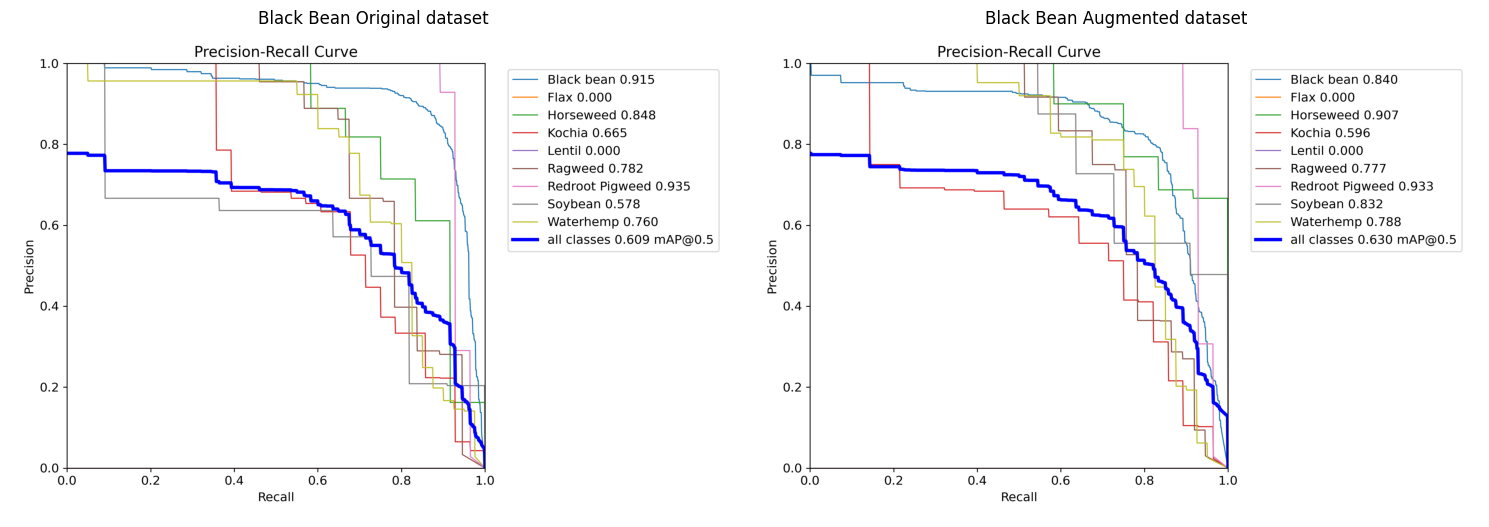

In [8]:
PATH_ORIGINAL = ORIGINAL_PATHS['plot_pr']
PATH_AUGMENTED = AUGMENTED_PATHS['plot_pr']

TITLE_ORIGINAL = ORIGINAL_PROJECT_NAME.replace('_', ' ').title()
TITLE_AUGMENTED = AUGMENTED_PROJECT_NAME.replace('_', ' ').title()

%matplotlib inline

try:
    img_original = Image.open(PATH_ORIGINAL)
    img_augmented = Image.open(PATH_AUGMENTED)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    axes[0].imshow(img_original)
    axes[0].set_title(f'{TITLE_ORIGINAL} dataset')
    axes[0].axis('off') 

    axes[1].imshow(img_augmented)
    axes[1].set_title(f'{TITLE_AUGMENTED} dataset')
    axes[1].axis('off') 

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: One or both PR curve plots were not found.")
    print("Please ensure both the Baseline and Augmented models have been trained and have saved 'BoxPR_curve.png' in the correct folders.")
except Exception as e:
    print(f"An unexpected error occurred during image display: {e}")